In [1]:
"""
This script is used to plot metrics for the substrate/product prediction task
"""

import json
import re
from rdkit import Chem, RDLogger

from Utils.Utils_plot import (
    plot_average_tanimoto_histogram, 
    plot_smiles_grid_tight,
    compute_tanimoto_similarity, 
    analyze_tanimoto_of_branching, 
    plot_average_pie_chart
)

In [ ]:
# EXPERIMENT_FILE_PREDICTIONS = "Logs_prediction/Pred_target_pairs_Finetuning_substrate_70B_r16_alpha32_lr0.0002_linear_full_5378130"  
# EXPERIMENT_FILE_ACCURACY = "Logs_accuracy/Accuracy_counts_Finetuning_substrate_70B_r16_alpha32_lr0.0002_linear_full_5378130"
EXPERIMENT_FILE_PREDICTIONS = "Logs_prediction/Pred_target_pairs_Finetuning_product_70B_r16_alpha32_lr0.0002_linear_full_5378111"
EXPERIMENT_FILE_ACCURACY = "Logs_accuracy/Accuracy_counts_Finetuning_product_70B_r16_alpha32_lr0.0002_linear_full_5378111"
GROUND_TRUTH_FILE = "Data_json/product_test_set.json"
PRODUCTS = True
TEST_SET_SIZE  = 857            # 857 for products, 837 for substrates
GRID_START = 22                 # 22 for products, 12 for substrates
GRID_END = 27                   # 27 for products, 17 for substrates
TANIMOTO_BINS = 30
TANIMOTO_COLOR = 'royalblue'    # 'royalblue' for products, 'green' for substrates
PIE_COLOR = 'blue'              # 'blue' for products, 'green' for substrates

In [4]:
def extract_smiles_from_text(text, regex_pattern):
    """Extract the first SMILES string using a given regex pattern."""
    matches = regex_pattern.findall(text)
    return matches[0] if matches else ""


def evaluate_smiles_prediction(
    prediction,
    ground_truth,
    results_dict,
    other_outputs = None,
) -> dict:
    """
    Evaluate a predicted SMILES string against ground truth + optionally alternative answers.
    Categorizes results into one of 5 types and updates results_dict in-place.
    """
    try:
        mol_gt = Chem.MolFromSmiles(ground_truth)
        mol_pred = Chem.MolFromSmiles(prediction)
        if mol_pred is None:
            results_dict["invalid"] += 1
            return results_dict

        canonical_gt = Chem.MolToSmiles(mol_gt, canonical=True)
        canonical_pred = Chem.MolToSmiles(mol_pred, canonical=True)

        if prediction == ground_truth:
            results_dict["canonical_match"] += 1
        elif canonical_pred == canonical_gt and prediction != ground_truth:
            results_dict["noncanonical_match"] += 1
        elif other_outputs:
            for alt in other_outputs:
                mol_alt = Chem.MolFromSmiles(alt)
                if mol_alt is None:
                    continue
                canonical_alt = Chem.MolToSmiles(mol_alt, canonical=True)
                if prediction == canonical_alt:
                    results_dict["canonical_match"] += 1
                    return results_dict
                if canonical_pred == canonical_alt:
                    results_dict["noncanonical_match"] += 1
                    return results_dict
        if canonical_pred != canonical_gt and prediction == canonical_pred:
            results_dict["canonical_valid"] += 1
        elif canonical_pred != canonical_gt:
            results_dict["noncanonical_valid"] += 1
    except Exception as e:
        print(f"[ERROR] Failed to evaluate SMILES: {prediction}. Reason: {e}")
        results_dict["invalid"] += 1
    return results_dict


In [5]:
def process_data_single_file(experiment_path, ground_truth_path, pattern):
    """
    Process a single experiment file with prediction lists and ground truths.

    Returns:
        averaged_results: dict with category counts averaged across lists
        all_category_counts: list of dicts, one per list
        all_tanimoto_lists: list of Tanimoto value lists
        matching_pairs: list of (pred, gt) SMILES where similarity = 1.0
    """
    with open(experiment_path, 'r') as f:
        experiment_data = json.load(f)

    with open(ground_truth_path, 'r') as f:
        ground_truth_data = json.load(f)

    ground_truth_smiles = [entry['raw_output'] for entry in ground_truth_data]
    other_truths = [entry.get('other_raw_outputs', []) for entry in ground_truth_data]

    pattern = pattern or re.compile(r'<SMILES>\s*(.*?)\s*</SMILES>')

    all_category_counts = []
    all_tanimoto_lists = []
    

    for prediction_list in experiment_data:
        categories = {
            "canonical_match": 0,
            "noncanonical_match": 0,
            "canonical_valid": 0,
            "noncanonical_valid": 0,
            "invalid": 0
        }
        tanimoto_values = []
        matching_pairs = []

        for i, (pred_raw, gt, others) in enumerate(zip(prediction_list, ground_truth_smiles, other_truths)):
            pred_smiles = extract_smiles_from_text(pred_raw, pattern)
            pre_valid_1 = categories["canonical_valid"]
            pre_valid_2 = categories["noncanonical_valid"]

            evaluate_smiles_prediction(pred_smiles, gt, categories, others)

            # Compute Tanimoto if we got a valid molecule
            if categories["canonical_valid"] > pre_valid_1 or categories["noncanonical_valid"] > pre_valid_2:
                t1, t2 = compute_tanimoto_similarity(pred_smiles, gt)
                tanimoto_values.append(t1)

                if t1 == 1.0:
                    matching_pairs.append((pred_smiles, gt))

        all_category_counts.append(categories)
        all_tanimoto_lists.append(tanimoto_values)

    averaged_results = {
        key: sum(d[key] for d in all_category_counts) // len(all_category_counts)
        for key in all_category_counts[0]
    }

    # Extract SMILES pairs where similarity == 1.0
    matching_pairs = [[pred, gt] for pred, gt in matching_pairs if len(gt) < 90]
    return averaged_results, all_category_counts, all_tanimoto_lists, matching_pairs


Loading and evaluating predictions...
{'canonical_match': 212, 'noncanonical_match': 8, 'canonical_valid': 505, 'noncanonical_valid': 89, 'invalid': 41}
Evaluation Summary:
canonical_match: 212
noncanonical_match: 8
canonical_valid: 505
noncanonical_valid: 89
invalid: 41

Tanimoto similarity histogram (average across runs)
592
597
595
Percentage of elements equal to 1.0: [10.641891891891891, 10.385259631490786, 9.747899159663866]
Percentage of elements above 0.95 but different from 1: [2.027027027027027, 1.1725293132328307, 1.8487394957983194]
Percentage of elements above 0.95: [12.66891891891892, 11.557788944723619, 11.596638655462185]
Percentage of elements above 0.85: [16.216216216216218, 14.40536013400335, 15.966386554621847]


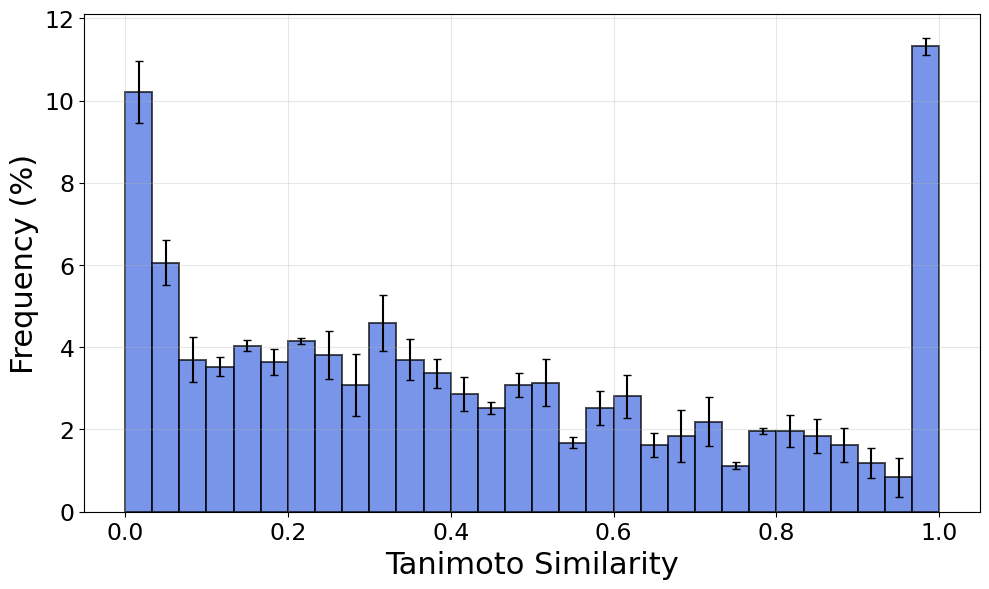


Displaying 5 perfectly matching predictions...


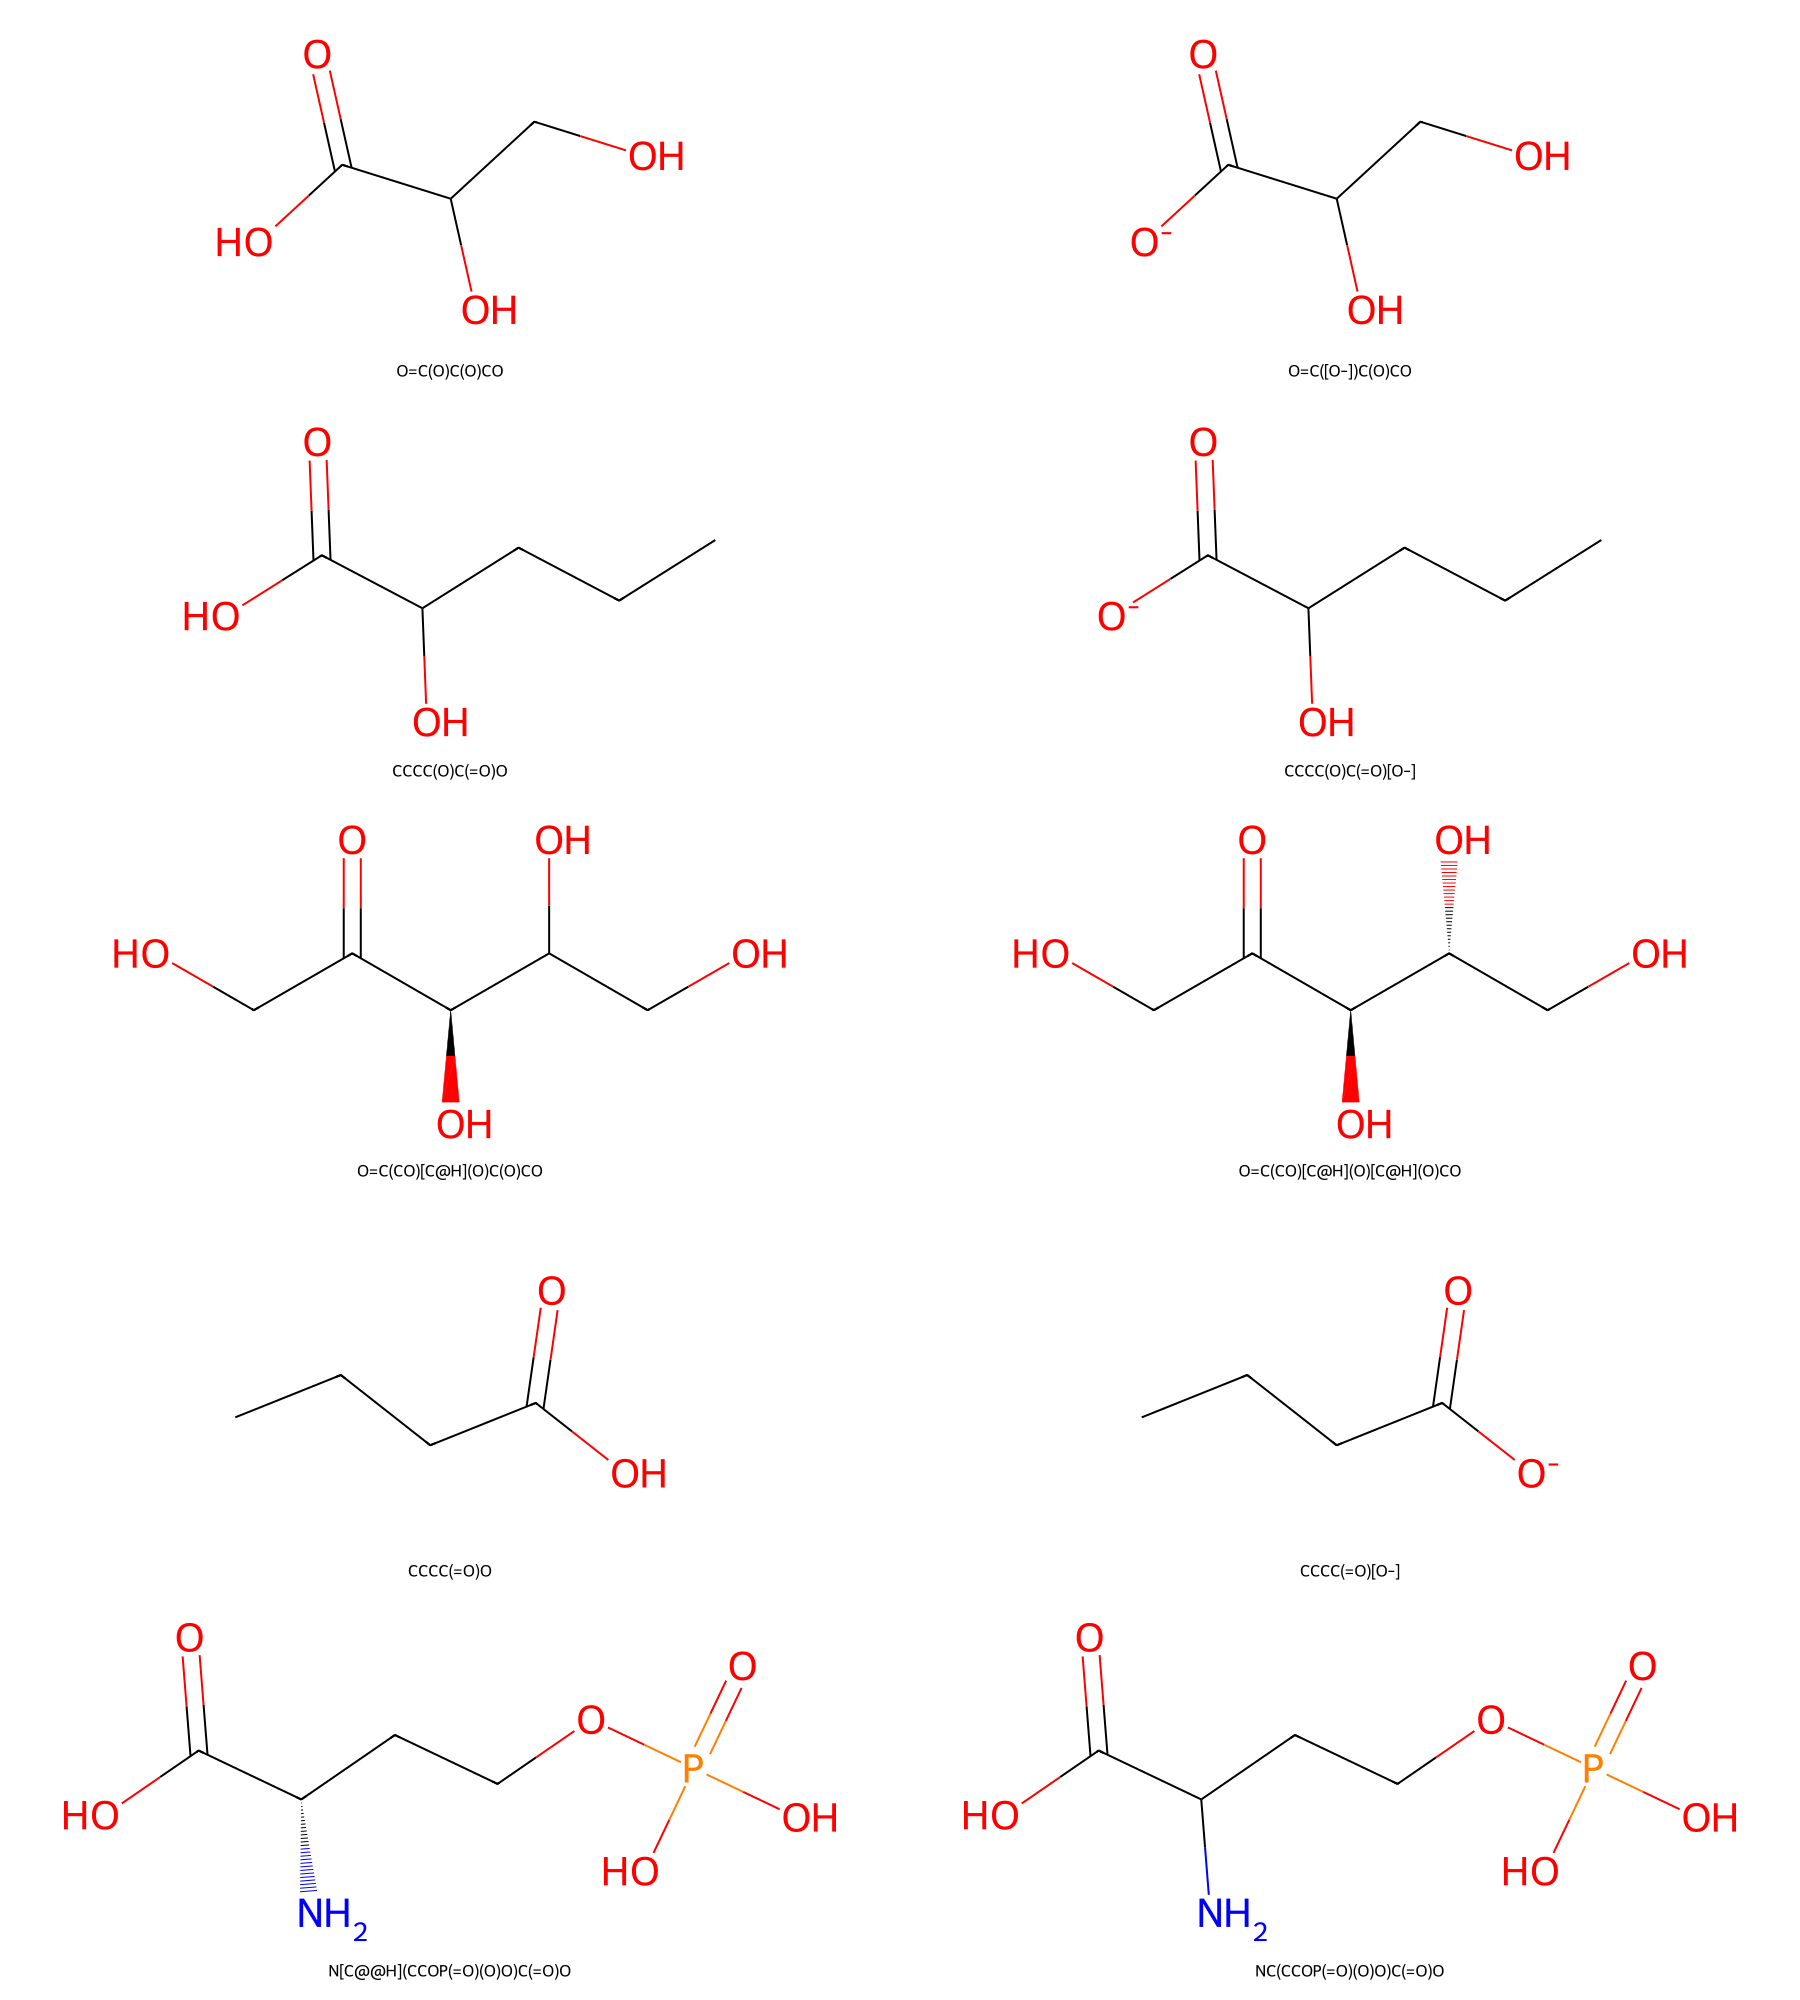

Branching similarity plot in ground truth alternatives
Low avg score: 0.19 for ['Nc1ncnc2c1ncn2C1OC(CCC(=O)c2cccc(C(=O)O)c2)C(O)C1O', 'C=C(Oc1cccc(C(=O)O)c1)C(=O)O']
Low avg score: 0.00 for ['O=P([O-])([O-])[O-]', 'CC(C)(N)CO']
Low avg score: 0.13 for ['O=P([O-])([O-])OP(=O)([O-])[O-]', 'Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OC(=O)[C@H]2CSC(=c3nc4c(s3)=CC(=O)C=C4)N2)[C@@H](O)[C@H]1O', 'CC(C)C(NC(=O)C(N)Cc1cnc[nH]1)C(=O)O']
Low avg score: 0.19 for ['Oc1ccc(Nc2cc(Cl)c(O)c(Cl)c2)cc1', 'O=C1C(Cl)=CC(=Nc2ccc([O-])cc2)C=C1Cl']
Low avg score: 0.03 for ['Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)O)O2)c(=O)[nH]c1=O', 'O=P([O-])([O-])OP(=O)([O-])[O-]']


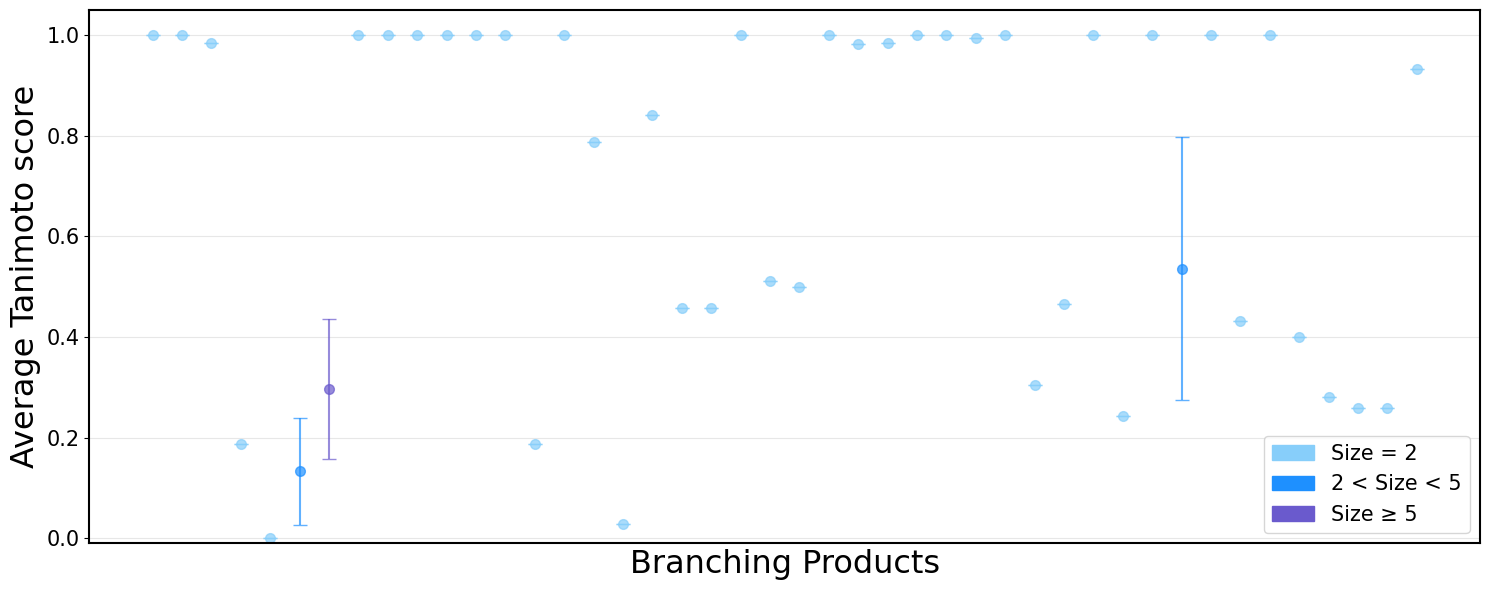


Pie chart (average across runs)
[{'canonical_match': 216, 'noncanonical_match': 7, 'canonical_valid': 499, 'noncanonical_valid': 89, 'invalid': 42}, {'canonical_match': 206, 'noncanonical_match': 9, 'canonical_valid': 502, 'noncanonical_valid': 92, 'invalid': 45}, {'canonical_match': 215, 'noncanonical_match': 10, 'canonical_valid': 504, 'noncanonical_valid': 87, 'invalid': 37}]
857 853.3333333333335


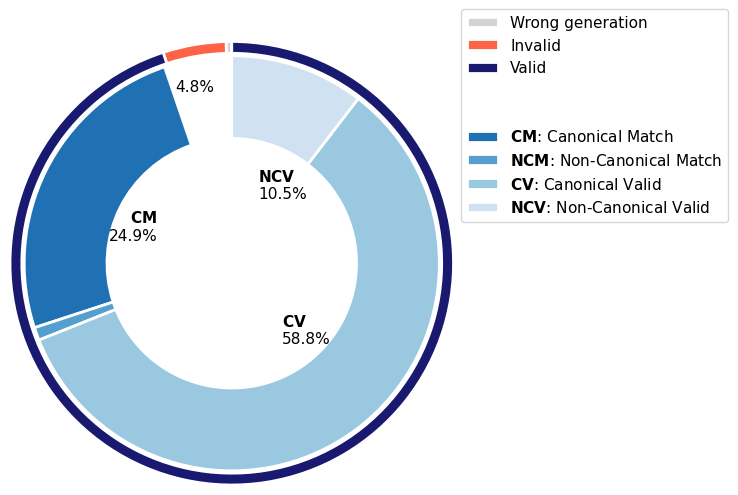

In [ ]:
def main():

    RDLogger.DisableLog('rdApp.*')
    pattern = re.compile(r'<SMILES>\s*(.*?)\s*</SMILES>')
    
    print("\nLoading and evaluating predictions...")
    categories, data_lists, tanimoto_lists, matching_pairs = process_data_single_file(
        EXPERIMENT_FILE_PREDICTIONS,
        GROUND_TRUTH_FILE,
        pattern
    )
    print(categories)

    print("Evaluation Summary:")
    for k, v in categories.items():
        print(f"{k}: {v}")
    
    # print("Plotting evaluation single experiment pie chart...")
    # plot_pie_chart(categories, total_len = TEST_SET_SIZE)

    print("\nTanimoto similarity histogram (average across runs)")
    plot_average_tanimoto_histogram(tanimoto_lists, bins=TANIMOTO_BINS, color=TANIMOTO_COLOR)

    if matching_pairs:
        print(f"\nDisplaying {GRID_END - GRID_START} perfectly matching predictions...")
        smiles_matrix = matching_pairs[GRID_START:GRID_END]
        legends_matrix = matching_pairs[GRID_START:GRID_END]
        img = plot_smiles_grid_tight(smiles_matrix, legends_matrix)
        img = plot_smiles_grid_tight(smiles_matrix, legends_matrix)
        from IPython.display import display
        display(img)
    else:
        print("\nNo Tanimoto = 1.0 pairs found to display.")

    print("Branching similarity plot in ground truth alternatives")
    analyze_tanimoto_of_branching(GROUND_TRUTH_FILE, prod=PRODUCTS)  # or prod=False if substrate
    
    print("\nPie chart (average across runs)")
    plot_average_pie_chart(EXPERIMENT_FILE_ACCURACY, den=TEST_SET_SIZE, palette=PIE_COLOR)


# Run script
if __name__ == "__main__":
    main()
